## test normilaztion

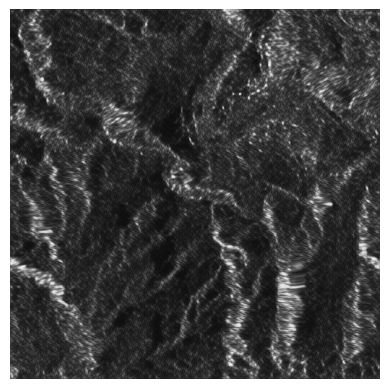

In [1]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("logs/2025-07-12T12-15-10_AutoencoderKL/images/train/reconstructions_gs-004500_e-000001_b-005002.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')  # 指定 colormap 为灰度
plt.axis('off')  # 去除坐标轴
plt.show()


In [2]:
# 检查最大最小值
print(img.min(), img.max())


121 255


In [3]:
import numpy as np
import matplotlib.pyplot as plt

def show_image_auto(img, title=None):
    plt.figure()
    if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
        plt.imshow(img.squeeze(), cmap='gray')
    else:
        plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


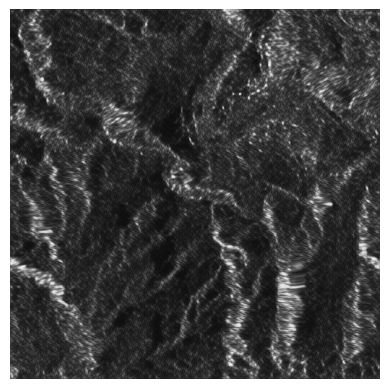

In [6]:
show_image_auto(img)

make task.json

In [12]:
import json

logdirs = [
    "logs/2025-07-14T18-43-47_W_KL_SO_2",
    "logs/2025-07-14T18-45-43_W_KL_CS_2",
    "logs/2025-07-17T16-05-07_W_KLP_SO",
    "logs/2025-07-18T15-40-30_W_KLP_SODG",
    "logs/2025-07-14T18-46-39_Ori_none_2",
    "logs/2025-07-15T16-18-12_Ori_SO",
]

ddpm_step = 200
ddim_step = 200

modes = [
    ("DDPM original", "eval_ddpm.py", "--ddpm_step", ddpm_step, None),
    ("DDPM degrade", "eval_ddpm.py", "--ddpm_step", ddpm_step, "basicsr.data.wavelet_dataset.WaveletSRDGDataset"),
    ("DDIM original", "eval_ddim.py", "--ddim_step", ddim_step, None),
    ("DDIM degrade", "eval_ddim.py", "--ddim_step", ddim_step, "basicsr.data.wavelet_dataset.WaveletSRDGDataset"),
]

tasks = {}
task_id = 1

for logdir in logdirs:
    for mode, script, step_flag, step_value, dataset in modes:
        tasks[str(task_id)] = {
            "logdir": logdir,
            "mode": mode,
            "script": script,
            "step_flag": step_flag,
            "step_value": step_value,
            "dataset": dataset
        }
        task_id += 1

# 构建最终字典
task_dict = {
    "tasks": tasks,
    "skip": []  # 初始为空，后续可以手动修改
}

# 保存到JSON文件
with open("tasks.json", "w") as f:
    json.dump(task_dict, f, indent=4)

print("任务列表已保存到 tasks.json (共24个任务)")


任务列表已保存到 tasks.json (共24个任务)


在forward中添加t_ori用于构造struct_cond,然后传给p_losses,p_losses需要使用LDMSRText的版本

## split 3ch-vae from v2-1_512-ema-pruned.ckpt

In [1]:
import torch
model=torch.load("ckpt/v2-1_512-ema-pruned.ckpt",map_location="cpu")
model.keys()

/home/flyingbucket/miniconda3/envs/stablesr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'callbacks', 'lr_schedulers', 'native_amp_scaling_state'])

In [2]:
model['state_dict'].keys()

dict_keys(['betas', 'alphas_cumprod', 'alphas_cumprod_prev', 'sqrt_alphas_cumprod', 'sqrt_one_minus_alphas_cumprod', 'log_one_minus_alphas_cumprod', 'sqrt_recip_alphas_cumprod', 'sqrt_recipm1_alphas_cumprod', 'posterior_variance', 'posterior_log_variance_clipped', 'posterior_mean_coef1', 'posterior_mean_coef2', 'model.diffusion_model.time_embed.0.weight', 'model.diffusion_model.time_embed.0.bias', 'model.diffusion_model.time_embed.2.weight', 'model.diffusion_model.time_embed.2.bias', 'model.diffusion_model.input_blocks.0.0.weight', 'model.diffusion_model.input_blocks.0.0.bias', 'model.diffusion_model.input_blocks.1.0.in_layers.0.weight', 'model.diffusion_model.input_blocks.1.0.in_layers.0.bias', 'model.diffusion_model.input_blocks.1.0.in_layers.2.weight', 'model.diffusion_model.input_blocks.1.0.in_layers.2.bias', 'model.diffusion_model.input_blocks.1.0.emb_layers.1.weight', 'model.diffusion_model.input_blocks.1.0.emb_layers.1.bias', 'model.diffusion_model.input_blocks.1.0.out_layers.0.

In [4]:
import torch

vae_state_dict = {k.replace("first_stage_model.", ""): v 
                  for k, v in model.items() if k.startswith("first_stage_model.")}

torch.save(vae_state_dict, "ckpt/vae_rgb_pretrained.pth")


## analyse eval_results.csv

In [1]:
import pandas as pd
exp=pd.read_csv("eval_results.csv")
exp

,ckpt_name,dataset,ddim_steps,ddpm_steps,enl,epi,eta,exp_name,fid,gt_path,lpips,mode,psnr,psnr_max,psnr_min,ssim,ssim_max,ssim_min
0,last.ckpt,WaveletSRDataset,NaN,200,1.834308,0.410741,NaN,Ori_none_2,98.182569,WHU_512_small,0.307593,DDPM,15.816352,NaN,NaN,0.280797,NaN,NaN
1,last.ckpt,WaveletSRDataset,NaN,200,2.907562,0.411446,NaN,W_KL_SO_2,97.573206,WHU_512_small,0.321831,DDPM,16.183748,NaN,NaN,0.293530,NaN,NaN
2,last.ckpt,WaveletSRDataset,NaN,200,1.782649,0.412186,NaN,W_KL_CS_2,98.479699,WHU_512_small,0.306256,DDPM,15.782554,25.737365,10.201180,0.279826,0.608539,0.037982
3,last.ckpt,WaveletSRDGDataset,NaN,200,2.674459,0.596833,NaN,W_KL_CS_2,37.353631,WHU_512_small,0.157124,DDPM,18.160259,26.553720,11.614324,0.439915,0.625170,0.037400
4,last.ckpt,WaveletSRDataset,NaN,200,1.830752,0.410677,NaN,Ori_none_2,98.181088,WHU_512_small,0.307612,DDPM,15.816394,25.659126,10.248174,0.280793,0.601071,0.035278
5,last.ckpt,WaveletSRDGDataset,NaN,200,2.713488,0.593533,NaN,Ori_none_2,37.277409,WHU_512_small,0.157211,DDPM,18.156454,26.891525,10.567971,0.438861,0.625732,0.036806


In [6]:
metrics=['exp_name','ckpt_name','mode','psnr','psnr_max','psnr_min']
exp[exp['dataset']=="WaveletSRDGDataset"][metrics]

,exp_name,ckpt_name,mode,psnr,psnr_max,psnr_min
3,W_KL_CS_2,last.ckpt,DDPM,18.160259,26.553720,11.614324
5,Ori_none_2,last.ckpt,DDPM,18.156454,26.891525,10.567971


In [8]:
exp[exp['dataset']=="WaveletSRDataset"][metrics]

,exp_name,ckpt_name,mode,psnr,psnr_max,psnr_min
0,Ori_none_2,last.ckpt,DDPM,15.816352,NaN,NaN
1,W_KL_SO_2,last.ckpt,DDPM,16.183748,NaN,NaN
2,W_KL_CS_2,last.ckpt,DDPM,15.782554,25.737365,10.201180
4,Ori_none_2,last.ckpt,DDPM,15.816394,25.659126,10.248174


## Eval Atuoencoder

In [2]:
import torch 
import cv2 
import os,contextlib,sys,lpips,shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import gaussian_kde
from tqdm import tqdm
from omegaconf import OmegaConf
from ldm.util import instantiate_from_config
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from pytorch_fid import fid_score

@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = fnull
        sys.stderr = fnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def evaluate(config_path, ckpt_path,fid_dir, **kwargs):
    if kwargs['gpu'] == -1 or not torch.cuda.is_available():
        device = torch.device("cpu")
    else:
        device = torch.device(f"cuda:{kwargs['gpu']}")

    # === 加载配置 ===
    config = OmegaConf.load(config_path)

    if kwargs['batch_size'] is not None:
        config.data.params.batch_size = kwargs['batch_size']
    if kwargs['dataset'] is not None:
        config.data.params.train.target=kwargs['dataset']
        config.data.params.validation.target=kwargs['dataset']
    if kwargs['gt_path'] is not None:
        config.data.params.train.params.gt_path = kwargs['gt_path']
        config.data.params.validation.params.gt_path = kwargs['gt_path']

    val_imgs=kwargs.get('val_imgs',False)
    print(f"val images: {val_imgs}")
    if val_imgs:
        img_score_path=kwargs['img_score_path']
        print(f"img_score_path: {img_score_path}")
    
    # === 加载模型 ===
    print("Loading Model ...")
    with suppress_stdout_stderr():
        model = instantiate_from_config(config.model)
        model.init_from_ckpt(ckpt_path)
        model.to(device).eval()


    # === 加载数据 ===
    data = instantiate_from_config(config.data)
    data.setup()
    dataloader = data.val_dataloader()

    # === LPIPS ===
    print("Loading lpips ...")
    with suppress_stdout_stderr():
        lpips_fn = lpips.LPIPS(net='alex').to(device)

    # === FID 目录准备 ===
    fid_real = os.path.join(fid_dir, "fid_real")
    fid_fake = os.path.join(fid_dir, "fid_fake")
    os.makedirs(fid_real, exist_ok=True)
    os.makedirs(fid_fake, exist_ok=True)

    psnr_list, ssim_list, lpips_list, enl_list, epi_list = [], [], [], [], []
    img_count = 0

    def min_max_normalize(img):
        img_min = np.min(img)
        img_max = np.max(img)
        if img_max - img_min < 1e-8:
            return np.zeros_like(img, dtype=np.uint8)
        norm_img = (img - img_min) / (img_max - img_min) * 255.0
        return norm_img.astype(np.uint8)/255.0

    with torch.no_grad():
        with tqdm(total=len(dataloader), desc="Processing batches", leave=True) as pbar:

            for batch in dataloader:   
                batch = {k: (v.to(device) if torch.is_tensor(v) else v) for k, v in batch.items()}

                # 生成样本
                try:
                    log = model.log_images(batch)
                except Exception as e:
                    print(f"使用自定义参数失败: {e}")
                    print("尝试使用默认参数...")
                    log = model.log_images(batch, N=batch['lq_image'].shape[0], sample=True)

                inputs = log["inputs"].detach().cpu().numpy()
                recons = log["reconstructions"].detach().cpu().numpy()

                B = inputs.shape[0]

                records_of_this_batch=[]
                for i in range(B):
                    gt = min_max_normalize(inputs[i,0])
                    pred = min_max_normalize(recons[i,0])

                    # 保存 FID 图片
                    gt_img = (gt * 255).clip(0,255).astype(np.uint8)
                    pred_img = (pred * 255).clip(0,255).astype(np.uint8)

                    cv2.imwrite(os.path.join(fid_real, f"{img_count}.png"), gt_img)
                    cv2.imwrite(os.path.join(fid_fake, f"{img_count}.png"), pred_img)

                    img_count += 1

                    # === PSNR & SSIM ===
                    psnr = compare_psnr(gt, pred, data_range=1.0)
                    ssim = compare_ssim(gt, pred, data_range=1.0)
                    psnr_list.append(psnr)
                    ssim_list.append(ssim)

                    # === LPIPS ===
                    gt_tensor = torch.from_numpy(gt).unsqueeze(0).unsqueeze(0).to(device).float()
                    pred_tensor = torch.from_numpy(pred).unsqueeze(0).unsqueeze(0).to(device).float()
                    lp = lpips_fn(gt_tensor.repeat(1,3,1,1), pred_tensor.repeat(1,3,1,1))
                    lpips_list.append(lp.item())

                    # === ENL ===
                    mean_pred = np.mean(pred)
                    var_pred = np.var(pred)
                    enl = (mean_pred ** 2) / (var_pred + 1e-8)
                    enl_list.append(enl)

                    # === EPI（Sobel边缘强度比）===
                    gt_edges = cv2.Sobel(gt, cv2.CV_64F, 1, 1, ksize=3)
                    pred_edges = cv2.Sobel(pred, cv2.CV_64F, 1, 1, ksize=3)
                    epi = np.sum(np.abs(pred_edges)) / (np.sum(np.abs(gt_edges)) + 1e-8)
                    epi_list.append(epi)

                    if val_imgs:
                        img_path=batch['gt_path'][i]
                        img_path=os.path.basename(img_path)
                        if not isinstance(img_path,str):
                            print(type(img_path),"\n",img_path)
                            raise ValueError("img_path should be a str")
                        # else:
                        #     print(img_path)
                        #     raise ValueError("img_path is not a list mabey err in saving df")

                        metrics_of_this_img={
                            'img':img_path,
                            'psnr':psnr,
                            'ssim':ssim,
                            'lpips':lp.item(),
                            'enl':enl,
                            'epi':epi

                        }
                        records_of_this_batch.append(metrics_of_this_img)
                
                if val_imgs:
                    df_batch = pd.DataFrame(records_of_this_batch)
                    df_batch.to_csv(
                        img_score_path,
                        mode='a', 
                        header=not os.path.exists(img_score_path),
                        index=False,
                        encoding='utf-8'
                    )
                pbar.update(1)

    # === FID ===
    print("Calculating FID")
    fid = fid_score.calculate_fid_given_paths([fid_real, fid_fake], batch_size=2, device=device, dims=2048)

    shutil.rmtree(fid_real)
    shutil.rmtree(fid_fake)  

    psnr=np.mean(psnr_list)
    psnr_max=np.max(psnr_list)
    psnr_min=np.min(psnr_list)
    ssim=np.mean(ssim_list)
    ssim_max=np.max(ssim_list)
    ssim_min=np.min(ssim_list)
    lpips_val=np.mean(lpips_list)
    enl=np.mean(enl_list)
    epi=np.mean(epi_list)

    result_dict = {
        "psnr": psnr,
        "psnr_max": psnr_max,
        "psnr_min": psnr_min,
        "ssim": ssim,
        "ssim_max": ssim_max,
        "ssim_min": ssim_min,
        "lpips": lpips_val,
        "fid": fid,
        "enl": enl,
        "epi": epi,
    }
    if val_imgs:
        print(f"saved image scores to {img_score_path}")
    print("eval finished")
    return result_dict,psnr_list,ssim_list

def bootstrap_ci(data, confidence=0.95, n_bootstrap=10000):
    data = np.array(data)
    boot_samples = np.random.choice(data, (n_bootstrap, len(data)), replace=True)
    boot_means = np.mean(boot_samples, axis=1)
    lower = np.percentile(boot_means, (1-confidence)/2*100)
    upper = np.percentile(boot_means, (1+confidence)/2*100)
    return np.mean(data), lower, upper

def show_res(res_dict,psnr_list,ssim_list):


    for key,val in res_dict.items():
        print(f"{key}: {val}")
    print("\n")
    confidence = 0.95

    # mean = np.mean(data)
    # sem = stats.sem(data)  # 标准误差

    # ci = stats.t.interval(confidence, df=len(data)-1, loc=mean, scale=sem)
    # 假设 psnr_list 和 ssim_list 是已有的列表或 numpy 数组
    psnr_array = np.array(psnr_list)
    ssim_array = np.array(ssim_list)

    # calculate ci
    mean_psnr=np.mean(psnr_array)
    sem_psnr=stats.sem(psnr_array)
    ci_psnr=stats.t.interval(confidence,df=len(psnr_array)-1,loc=mean_psnr,scale=sem_psnr)
    print(f"T Mean PSNR: {mean_psnr:.2f}, 95% CI: [{ci_psnr[0]:.2f}, {ci_psnr[1]:.2f}]")
    
    mean_ssim=np.mean(ssim_array)
    sem_ssim=stats.sem(ssim_array)
    ci_ssim=stats.t.interval(confidence,df=len(ssim_array)-1,loc=mean_ssim,scale=sem_ssim)
    print(f"T Mean SSIM: {mean_ssim:.2f}, 95% CI: [{ci_ssim[0]:.2f}, {ci_ssim[1]:.2f}]")
    
    b_mean_psnr,b_l_psnr,b_u_psnr=bootstrap_ci(psnr_array)
    b_mean_ssim,b_l_ssim,b_u_ssim=bootstrap_ci(ssim_array)
    print(f"Bootstrap Mean PSNR: {b_mean_psnr:.2f}, 95% CI: [{b_l_psnr:.2f}, {b_u_psnr:.2f}]")
    print(f"Bootstrap Mean SSIM: {b_mean_ssim:.2f}, 95% CI: [{b_l_ssim:.2f}, {b_u_ssim:.2f}]")
    # PSNR图
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle("PSNR")

    # Boxplot
    ax[0].boxplot(psnr_array, vert=False)
    ax[0].set_title("Boxplot of PSNR")

    # KDE
    kde = gaussian_kde(psnr_array)
    x_range = np.linspace(psnr_array.min(), psnr_array.max(), 200)
    ax[1].fill_between(x_range, kde(x_range), alpha=0.5)
    ax[1].plot(x_range, kde(x_range))
    ax[1].set_title("KDE of PSNR")

    # SSIM图
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle("SSIM")

    # Boxplot
    ax[0].boxplot(ssim_array, vert=False)
    ax[0].set_title("Boxplot of SSIM")

    # KDE
    kde = gaussian_kde(ssim_array)
    x_range = np.linspace(ssim_array.min(), ssim_array.max(), 200)
    ax[1].fill_between(x_range, kde(x_range), alpha=0.5)
    ax[1].plot(x_range, kde(x_range))
    ax[1].set_title("KDE of SSIM")

    plt.show()


/home/flyingbucket/miniconda3/envs/stablesr/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
%config InlineBackend.figure_formats=['svg']

### val images 

#### use AKL_10 to val WHU_512_small

val images: True
img_score_path: image_scores_3000.csv


Processing batches: 100%|██████████| 750/750 [15:58<00:00,  1.28s/it]


Calculating FID


100%|██████████| 1500/1500 [00:21<00:00, 69.22it/s]


saved image scores to image_scores_3000.csv
eval finished
psnr: 18.170532755992742
psnr_max: 26.40574840851919
psnr_min: 12.807818651195841
ssim: 0.4407373305477927
ssim_max: 0.6252456469333622
ssim_min: 0.05005181854637584
lpips: 0.156426471610864
fid: 37.06540567719264
enl: 2.565962894545244
epi: 0.6020474281948562


T Mean PSNR: 18.17, 95% CI: [18.11, 18.23]
T Mean SSIM: 0.44, 95% CI: [0.44, 0.44]
Bootstrap Mean PSNR: 18.17, 95% CI: [18.11, 18.24]
Bootstrap Mean SSIM: 0.44, 95% CI: [0.44, 0.44]


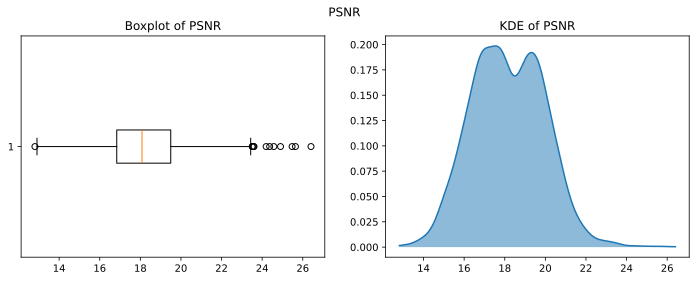

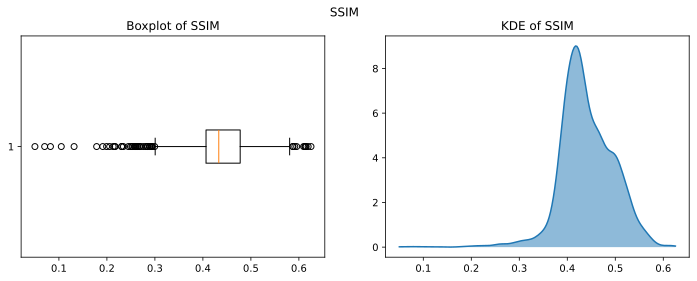

In [10]:
args={
    "gpu":2,
    "dataset":None,
    "gt_path":"../DataStore/WHU_512_small",
    "batch_size":4,
    "val_imgs":True,
    "img_score_path":"image_scores_3000.csv"
}
ckpt_path="ckpt/AKL_10.ckpt"
config_path="configs/autoencoder/autoencoderKL_64.yaml"
fid_dir="debug_out/AKL_10"

if not os.path.exists(fid_dir):
    os.mkdir(fid_dir)

res_dict,psnr_list,ssim_list=evaluate(config_path,ckpt_path,fid_dir,**args)

show_res(res_dict,psnr_list,ssim_list)

#### use AKL_10 to eval WHU_512 full

val images: True
img_score_path: image_scores_WHU_full.csv


Processing batches: 100%|██████████| 6500/6500 [2:18:13<00:00,  1.28s/it]  


Calculating FID


100%|██████████| 13000/13000 [03:11<00:00, 67.92it/s]


saved image scores to image_scores_WHU_full.csv
eval finished
psnr: 18.149214341484388
psnr_max: 27.570930994342994
psnr_min: 9.705640650418392
ssim: 0.44146458613093903
ssim_max: 0.6386105933642273
ssim_min: 0.04983853220183426
lpips: 0.15604381237895443
fid: 31.127658687186624
enl: 2.4696191062543162
epi: 0.6018436876770362


T Mean PSNR: 18.15, 95% CI: [18.13, 18.17]
T Mean SSIM: 0.44, 95% CI: [0.44, 0.44]
Bootstrap Mean PSNR: 18.15, 95% CI: [18.13, 18.17]
Bootstrap Mean SSIM: 0.44, 95% CI: [0.44, 0.44]


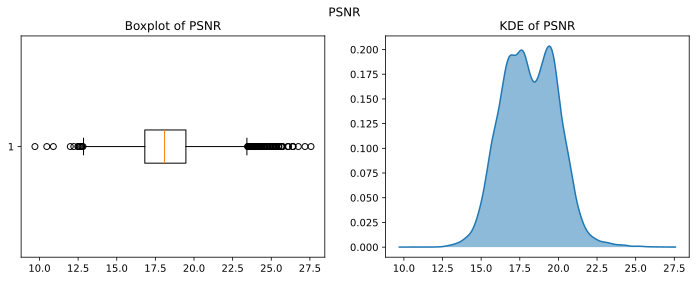

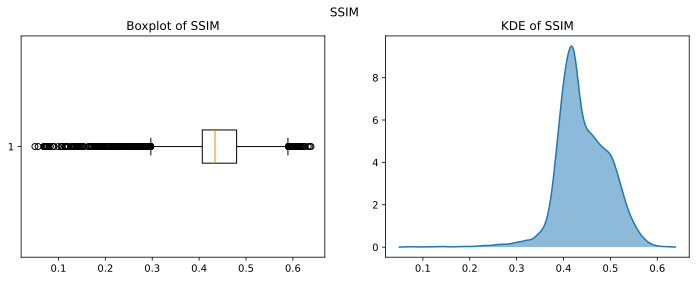

In [4]:
args={
    "gpu":2,
    "dataset":None,
    "gt_path":"../DataStore/WHU_512",
    "batch_size":4,
    "val_imgs":True,
    "img_score_path":"image_scores_WHU_full.csv"
}
ckpt_path="ckpt/AKL_10.ckpt"
config_path="configs/autoencoder/autoencoderKL_64.yaml"
fid_dir="debug_out/AKL_10"

if not os.path.exists(fid_dir):
    os.mkdir(fid_dir)

res_dict,psnr_list,ssim_list=evaluate(config_path,ckpt_path,fid_dir,**args)

show_res(res_dict,psnr_list,ssim_list)

### RGB AutoencoderKL

In [17]:
args={
    "gpu":1,
    "dataset":None,
    "gt_path":"../DataStore/WHU_512_small",
    "batch_size":6
}
ckpt_path="ckpt/vae_rgb_pretrained.pth"
config_path="configs/autoencoder/original_tri.yaml"
fid_dir="debug_out/AKP_tri"

if not os.path.exists(fid_dir):
    os.mkdir(fid_dir)

res_dict,psnr_list,ssim_list=evaluate(config_path,ckpt_path,fid_dir,**args)

Processing batches: 100%|██████████| 500/500 [08:30<00:00,  1.02s/it]


Calculating FID


100%|██████████| 1500/1500 [00:24<00:00, 61.64it/s]


eval finished


psnr: 6.800902252605644
psnr_max: 10.356002335611167
psnr_min: 1.9569448345298501
ssim: 0.025241179508721245
ssim_max: 0.049118048628357426
ssim_min: 0.005123697830479566
lpips: 0.631137172649304
fid: 346.54672743157244
enl: 106.0259296107562
epi: 0.3026422932212778


T Mean PSNR: 6.80, 95% CI: [6.77, 6.83]
T Mean SSIM: 0.03, 95% CI: [0.02, 0.03]
Bootstrap Mean PSNR: 6.80, 95% CI: [6.77, 6.83]
Bootstrap Mean SSIM: 0.03, 95% CI: [0.02, 0.03]


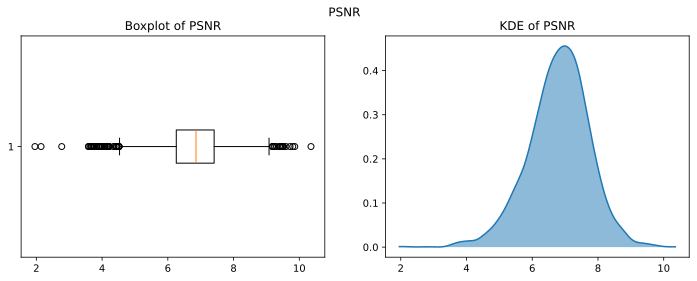

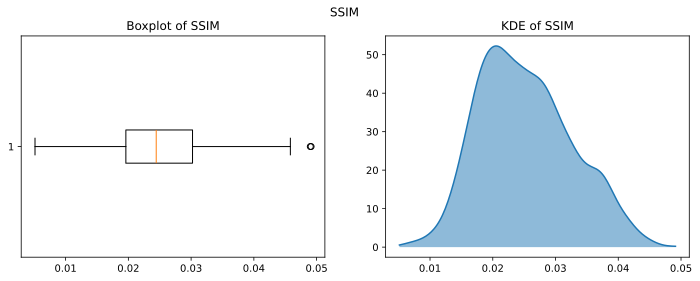

In [20]:
show_res(res_dict,psnr_list,ssim_list)

### RGBKL switch in/out layer 

val images: False
Loading Model ...
Loading lpips ...


Processing batches: 100%|██████████| 750/750 [08:33<00:00,  1.46it/s]


Calculating FID


100%|██████████| 1500/1500 [00:19<00:00, 76.00it/s]


eval finished
psnr: 18.193608383374762
psnr_max: 31.035783876993044
psnr_min: 12.757606037223754
ssim: 0.43438605411701203
ssim_max: 0.6607310084818202
ssim_min: 0.14650980580911074
lpips: 0.1625489722409596
fid: 38.64274349350967
enl: 2.4983049356043594
epi: 0.6006512894122789


T Mean PSNR: 18.19, 95% CI: [18.12, 18.26]
T Mean SSIM: 0.43, 95% CI: [0.43, 0.44]
Bootstrap Mean PSNR: 18.19, 95% CI: [18.13, 18.26]
Bootstrap Mean SSIM: 0.43, 95% CI: [0.43, 0.44]


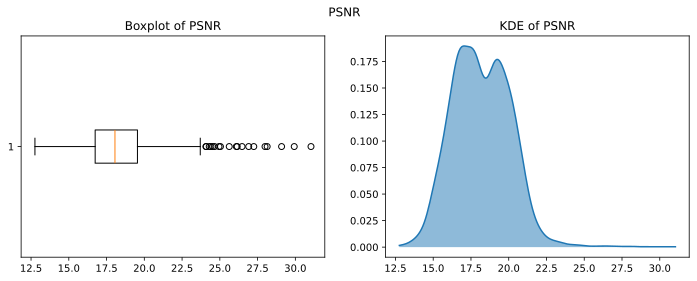

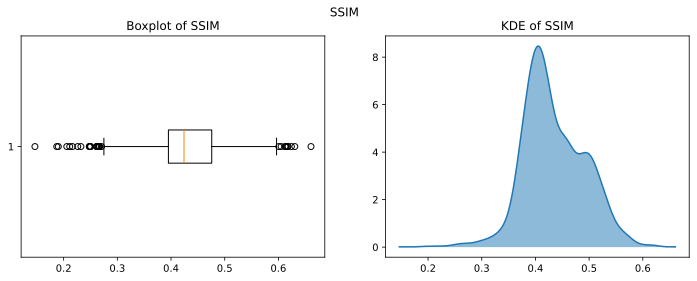

In [8]:
args={
    "gpu":1,
    "dataset":None,
    "gt_path":"../DataStore/WHU_512_small",
    "batch_size":4
}
ckpt_path="logs/2025-07-19T14-10-40_AutoencoderKL_pre/checkpoints/last.ckpt"
config_path="configs/autoencoder/autoencoder_kl_pre.yaml"
fid_dir="debug_out/AKL_pre"

if not os.path.exists(fid_dir):
    os.mkdir(fid_dir)

res_dict,psnr_list,ssim_list=evaluate(config_path,ckpt_path,fid_dir,**args)

show_res(res_dict,psnr_list,ssim_list)

val images: False
Loading Model ...
Loading lpips ...


Processing batches: 100%|██████████| 1/1 [00:06<00:00,  6.73s/it]


Calculating FID


100%|██████████| 1/1 [00:00<00:00,  5.63it/s]


eval finished
psnr: 17.028751217177046
psnr_max: 18.58625668702587
psnr_min: 15.471245747328226
ssim: 0.4161284096983737
ssim_max: 0.4682188339113301
ssim_min: 0.3640379854854174
lpips: 0.18692942708730698
fid: 230.02156691924898
enl: 2.9672472593268817
epi: 0.5940264151841299


T Mean PSNR: 17.03, 95% CI: [-2.76, 36.82]
T Mean SSIM: 0.42, 95% CI: [-0.25, 1.08]
Bootstrap Mean PSNR: 17.03, 95% CI: [15.47, 18.59]
Bootstrap Mean SSIM: 0.42, 95% CI: [0.36, 0.47]


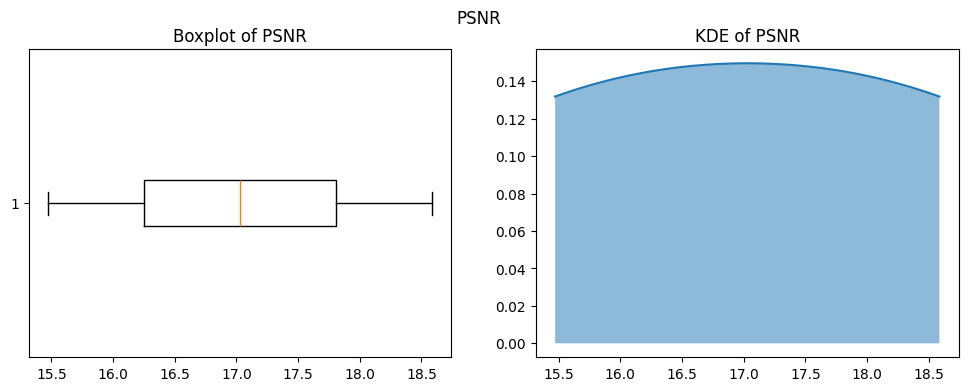

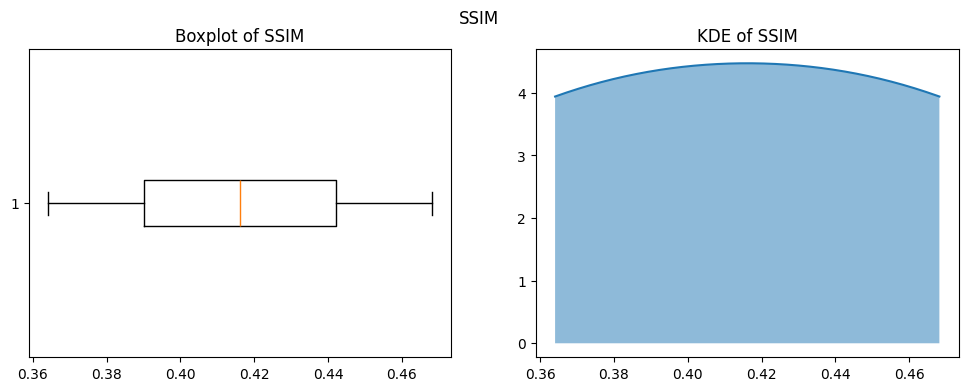

In [2]:
args={
    "gpu":2,
    "dataset":None,
    "gt_path":"../DataStore/WHU_512_extra_small",
    "batch_size":4
}
ckpt_path="logs/2025-07-19T14-10-40_AutoencoderKL_pre/checkpoints/epoch=000006.ckpt"
config_path="configs/autoencoder/autoencoder_kl_pre.yaml"
fid_dir="debug_out/AKL_pre"

if not os.path.exists(fid_dir):
    os.mkdir(fid_dir)

res_dict,psnr_list,ssim_list=evaluate(config_path,ckpt_path,fid_dir,**args)

show_res(res_dict,psnr_list,ssim_list)

### AKL_10

Processing batches: 100%|██████████| 750/750 [16:06<00:00,  1.29s/it]


Calculating FID


100%|██████████| 1500/1500 [00:25<00:00, 58.86it/s]


eval finished
psnr: 18.170471835111872
psnr_max: 26.385231417490633
psnr_min: 12.813553179233528
ssim: 0.4407370401798327
ssim_max: 0.6254162873262782
ssim_min: 0.04997940459342644
lpips: 0.15642651672723393
fid: 37.06627732562208
enl: 2.5663761665483427
epi: 0.6020529607936159


T Mean PSNR: 18.17, 95% CI: [18.11, 18.23]
T Mean SSIM: 0.44, 95% CI: [0.44, 0.44]
Bootstrap Mean PSNR: 18.17, 95% CI: [18.11, 18.23]
Bootstrap Mean SSIM: 0.44, 95% CI: [0.44, 0.44]


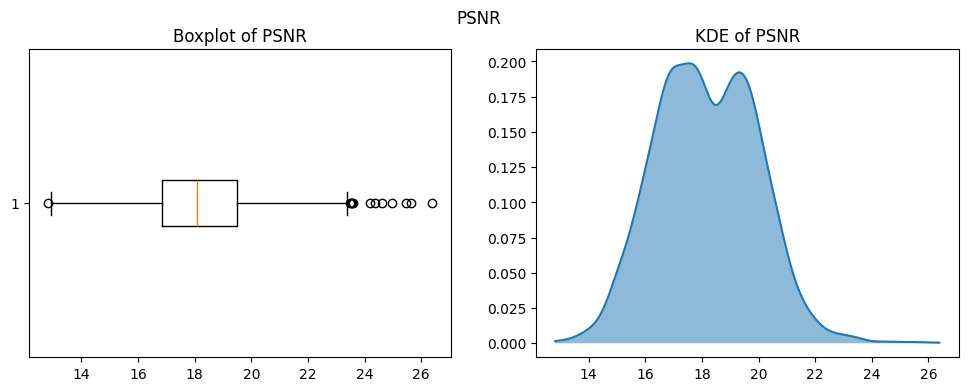

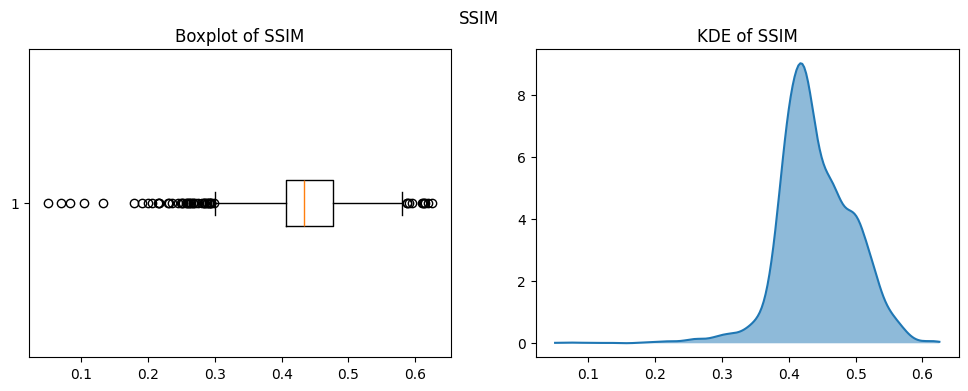

In [10]:
args={
    "gpu":2,
    "dataset":None,
    "gt_path":"../DataStore/WHU_512_small",
    "batch_size":4
}
ckpt_path="ckpt/AKL_10.ckpt"
config_path="configs/autoencoder/autoencoderKL_64.yaml"
fid_dir="debug_out/AKL_10"

if not os.path.exists(fid_dir):
    os.mkdir(fid_dir)

res_dict,psnr_list,ssim_list=evaluate(config_path,ckpt_path,fid_dir,**args)

show_res(res_dict,psnr_list,ssim_list)

### AKL_l1_only

val images: False
Loading Model ...
Loading lpips ...


Processing batches: 100%|██████████| 750/750 [08:32<00:00,  1.46it/s]


Calculating FID


100%|██████████| 1500/1500 [00:20<00:00, 73.01it/s]


eval finished
psnr: 17.407893544009127
psnr_max: 22.588002127965552
psnr_min: 7.866030129344082
ssim: 0.36905723584630534
ssim_max: 0.5439074961832131
ssim_min: 0.028838878361643887
lpips: 0.20499238521854082
fid: 45.95623634411106
enl: 3.518792812353188
epi: 0.5181447981756455


T Mean PSNR: 17.41, 95% CI: [17.35, 17.47]
T Mean SSIM: 0.37, 95% CI: [0.37, 0.37]
Bootstrap Mean PSNR: 17.41, 95% CI: [17.35, 17.47]
Bootstrap Mean SSIM: 0.37, 95% CI: [0.37, 0.37]


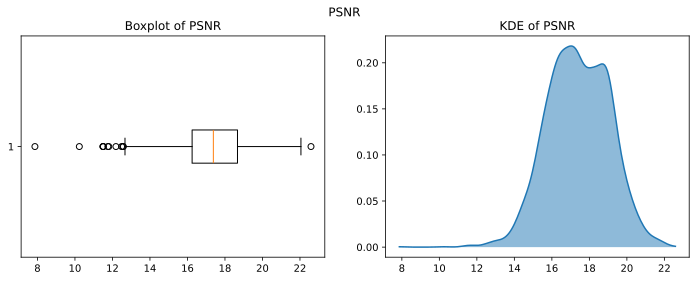

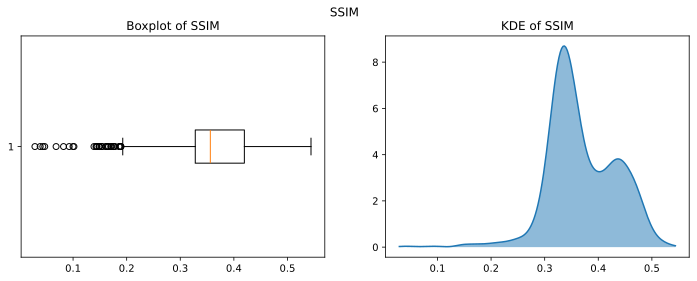

In [9]:
args={
    "gpu":1,
    "dataset":None,
    "gt_path":"../DataStore/WHU_512_small",
    "batch_size":4
}
ckpt_path="logs/2025-07-12T12-41-35_AutoencoderKL_no_GAN/checkpoints/last.ckpt"
config_path="configs/autoencoder/autoencoderKL_64.yaml"
fid_dir="debug_out/AKL_l1_only"

if not os.path.exists(fid_dir):
    os.mkdir(fid_dir)

res_dict,psnr_list,ssim_list=evaluate(config_path,ckpt_path,fid_dir,**args)

show_res(res_dict,psnr_list,ssim_list)

### z16

epoch 2 at 7-22-01:30

already best!

val images: False
Loading Model ...
Loading lpips ...


Processing batches: 100%|██████████| 750/750 [16:03<00:00,  1.28s/it]


Calculating FID


100%|██████████| 1500/1500 [00:22<00:00, 67.62it/s]


eval finished
psnr: 19.356894527550665
psnr_max: 28.04643404916195
psnr_min: 9.019088035311553
ssim: 0.5786598523648377
ssim_max: 0.7886340296903286
ssim_min: 0.025344072948922047
lpips: 0.19882085497801502
fid: 34.83912442603855
enl: 2.4980110359352685
epi: 0.5611238082633301


T Mean PSNR: 19.36, 95% CI: [19.29, 19.42]
T Mean SSIM: 0.58, 95% CI: [0.58, 0.58]
Bootstrap Mean PSNR: 19.36, 95% CI: [19.29, 19.42]
Bootstrap Mean SSIM: 0.58, 95% CI: [0.58, 0.58]


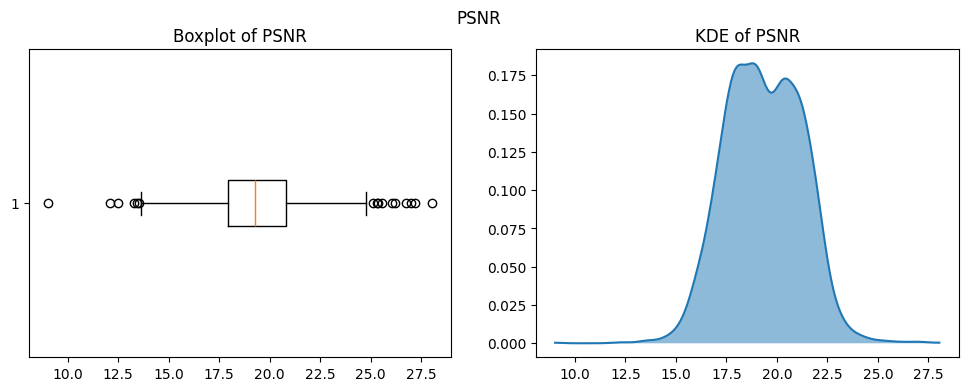

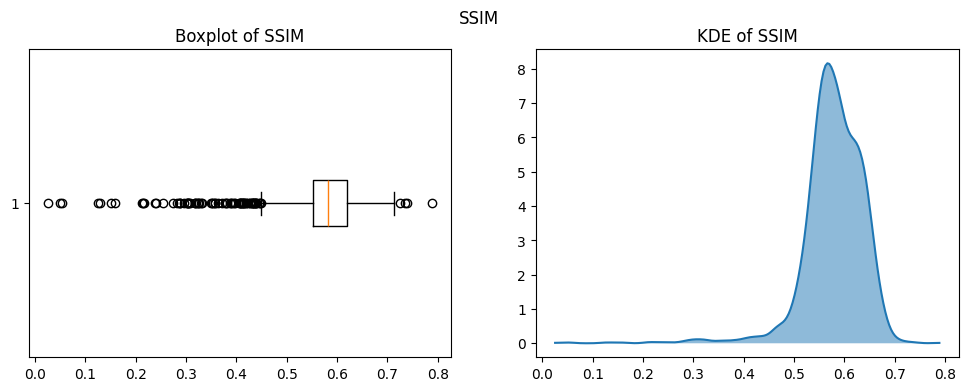

In [3]:
args={
    "gpu":3,
    "dataset":None,
    "gt_path":"../DataStore/WHU_512_small",
    "batch_size":4
}
ckpt_path="logs/2025-07-21T16-02-12_AutoencoderKL_z16/checkpoints/last.ckpt"
config_path="configs/autoencoder/autoencoder_kl_z16.yaml"
fid_dir="debug_out/AKLP"

if not os.path.exists(fid_dir):
    os.mkdir(fid_dir)

res_dict,psnr_list,ssim_list=evaluate(config_path,ckpt_path,fid_dir,**args)

show_res(res_dict,psnr_list,ssim_list)

### AKLP old

val images: False
Loading Model ...
Loading lpips ...


Processing batches: 100%|██████████| 750/750 [16:05<00:00,  1.29s/it]


Calculating FID


100%|██████████| 1500/1500 [00:22<00:00, 67.70it/s]


eval finished
psnr: 16.16178964511877
psnr_max: 25.979519462841886
psnr_min: 10.805966811966156
ssim: 0.2824790394551256
ssim_max: 0.4745463054318111
ssim_min: 0.05508452934906877
lpips: 0.21887770412365595
fid: 102.37797163900035
enl: 2.8074776880207453
epi: 0.6347252032558995


T Mean PSNR: 16.16, 95% CI: [16.11, 16.22]
T Mean SSIM: 0.28, 95% CI: [0.28, 0.28]
Bootstrap Mean PSNR: 16.16, 95% CI: [16.10, 16.22]
Bootstrap Mean SSIM: 0.28, 95% CI: [0.28, 0.28]


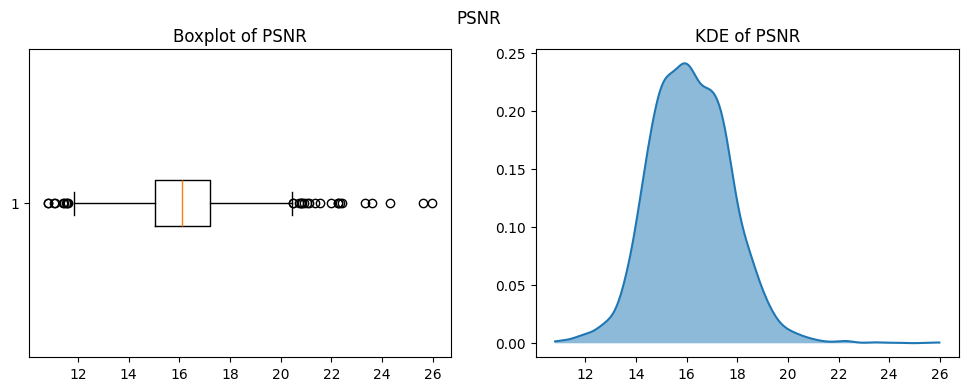

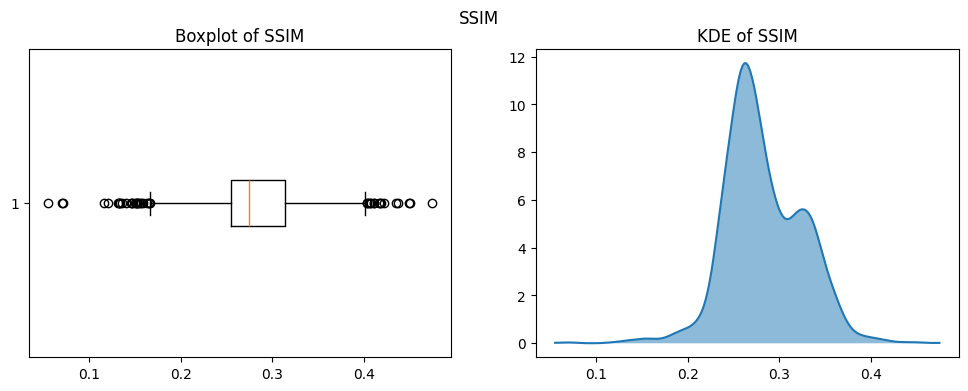

In [3]:
args={
    "gpu":3,
    "dataset":None,
    "gt_path":"../DataStore/WHU_512_small",
    "batch_size":4
}
ckpt_path="logs/2025-07-15T23-52-05_AutoencoderKLPlus/checkpoints/last.ckpt"
config_path="configs/autoencoder/autoencoder_klp.yaml"
fid_dir="debug_out/AKLP"

if not os.path.exists(fid_dir):
    os.mkdir(fid_dir)

res_dict,psnr_list,ssim_list=evaluate(config_path,ckpt_path,fid_dir,**args)

show_res(res_dict,psnr_list,ssim_list)

### AKLP retrain

### AKLP spade